In [1]:
import lumicks.pylake as lk
from scipy.signal import find_peaks
import pandas as pd
import numpy as np
import os
from os.path import join
from rich.progress import track
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True, style="white")

In [2]:
def func(t, a, b, tau, c):
    return a + b * np.exp(t / tau) + c * t

In [3]:
folder = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig1_system design/CTRAP"
os.chdir(folder)
fname = "20230501-182608 Scan NOTAG16.h5"
lkfile = lk.File(fname)
# Import data: Force in the x direction (pN)
force2x = lkfile["Force HF"]["Force 2x"]
# Downsample forces for finding peak
sample_rate = force2x.sample_rate
downsampled_rate = 5  # Hz
downsample_ratio = int(sample_rate / downsampled_rate)
force2x_downsamp = force2x.downsampled_by(downsample_ratio)
f = force2x_downsamp.data * 1e3  # fN
t = (
    force2x_downsamp.timestamps - force2x_downsamp.timestamps[0]
) / 1e9  # convert from ns to s

f_gradient = np.gradient(f)

peak_minheight = 0.0001
peak_distance = 200
peaks, peak_properties = find_peaks(
    f_gradient, height=peak_minheight, distance=peak_distance
)
heights = peak_properties["peak_heights"]
idx_max_peak_in_peaks = np.argmax(heights)
idx_max_peak_in_t = peaks[idx_max_peak_in_peaks]

# empirical: most fusion within 0.2 s
t_range_for_fitting = (
    t[idx_max_peak_in_t] - 0.1,
    t[idx_max_peak_in_t] + 0.1,
)
# take high frequency data for fitting
f_highfreq = force2x.data * 1e3
t_highfreq = (
    force2x.timestamps - force2x.timestamps[0]
) / 1e9  # convert from ns to s
selector = (t_highfreq > t_range_for_fitting[0]) & (
    t_highfreq < t_range_for_fitting[1]
)
f_tofit = f_highfreq[selector]
f_tofit = f_tofit - f_tofit.min()
t_tofit = t_highfreq[selector] * 1e3  # ms
t_tofit = t_tofit - t_tofit[0]
popt, pcov = curve_fit(
    func,
    t_tofit,
    f_tofit,
    method="trf",
    bounds=(
        [0, 1e-15, 1, 0],
        [10, 10, 1000, 0.5],
    ),
)

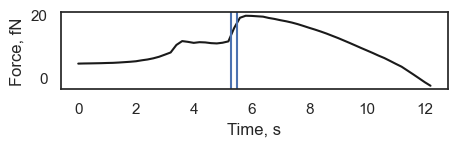

In [7]:
# show the selected range in the full trace
plt.figure(figsize=(5,1))
plt.plot(t, f, "k")
plt.axvline(t_range_for_fitting[0])
plt.axvline(t_range_for_fitting[1])
plt.xlabel("Time, s")
plt.ylabel("Force, fN")
plt.savefig(fname[:-3] + "-maxpeak.png", format="png")
plt.show()

1.5332652868803098 1.433350352425762e-05 15.559359476557104 0.010514956281767103
0.00011921048653434571 5.284876346623435e-12 0.03849080128539697 1.8739494235862884e-08


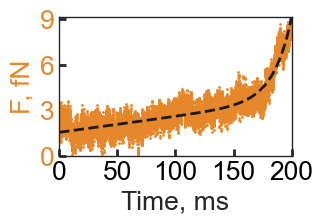

In [91]:
fontsize = 19
color = "#E7872B"
# plot fitting with raw data
fig, ax = plt.subplots(figsize=(3, 1.8))
ax.scatter(t_tofit, f_tofit, color=color, s=1)
t_toplot = np.linspace(t_tofit[0], t_tofit[-1], 100)
a, b, tau, c = popt
a_err, b_err, tau_err, c_err = np.diag(pcov)
f_fitted = func(t_toplot, a, b, tau, c)
ax.plot(t_toplot, f_fitted, color="k", lw=2, ls="--")
plt.xlim(t_tofit[0], t_tofit[-1])
plt.ylim(f_tofit.min(), f_tofit.max())
plt.xticks([0, 50, 100, 150, 200])
plt.yticks([0, 3, 6, 9])
ax.tick_params(
    axis="y",
    labelcolor=color,
    labelsize=fontsize,
    direction="in",
    length=5,
    width=2,
    reset=True,
    right=False,
)
ax.tick_params(
    axis="x",
    labelcolor="black",
    labelsize=fontsize,
    direction="in",
    length=5,
    width=2,
    reset=True,
    top=False,
)
plt.xlabel("Time, ms", fontsize=fontsize)
plt.ylabel("F, fN", fontsize=fontsize, color=color)
ax.spines[:].set_linewidth(1)
plt.savefig(fname[:-3] + "-fitting.png", format="png", dpi=300, bbox_inches="tight")

print(a, b, tau, c)
print(a_err, b_err, tau_err, c_err)

In [49]:
# histogram
df = pd.read_csv("fitting_largest_jump_results.csv")
selector = (df["SE_tau"] > 0.01) & (df["SE_tau"] < 100)
df = df[selector]
df_notag = df[df["fname"].str.contains("NOTAG")]
all_tau_ms = df_notag['tau, ms'].to_numpy()

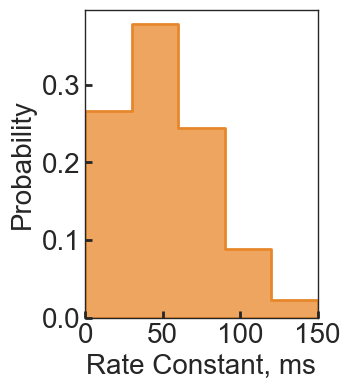

#Condensates: 45


In [89]:
fontsize = 20
binrange = (0, 150)
plt.figure(figsize=(3, 4))
ax = sns.histplot(
    data=all_tau_ms,
    bins=5,
    binrange=binrange,
    line_kws={"alpha": 0.99},
    stat="probability",
    color="#E7872B",
    lw=2,
    element="step",
)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=fontsize,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.xlim(binrange[0], binrange[1])
plt.xticks([0, 50, 100, 150])
plt.gca().set_axisbelow(False)
plt.xlabel("Rate Constant, ms", fontsize=fontsize)
plt.ylabel("Probability", fontsize=fontsize)
plt.savefig(
    "notag_fusion_rate_constant_histo.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)
plt.show()
print("#Condensates:", len(all_tau_ms))